In [111]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [112]:
train_df = pd.read_parquet("../train_final_v3.parquet")
val_df = pd.read_parquet("../validationA_v3.parquet")
cal_df = pd.read_parquet("../validationB_v3.parquet")

In [113]:
print(train_df.shape)
print(val_df.shape)
print(cal_df.shape)

(112768, 791)
(24164, 791)
(24164, 791)


In [114]:
X_train = train_df.drop(columns=['match'], axis=1)
X_val = val_df.drop(columns=['match'], axis=1)
y_train = train_df['match']
y_val = val_df['match']
X_cal = cal_df.drop(columns=['match'])
y_cal = cal_df['match']

In [115]:
X_train_raw = X_train
X_val_raw = X_val
X_test_raw = X_cal

In [116]:
for df in (X_train, X_val, X_cal):
    df['review_span'] = (df['max_date'] - df['min_date']).dt.days
    df.drop(['min_date', 'max_date'], axis=1, inplace=True)

for df in (X_train, X_val, X_cal):
    df['missing_price'] = df['missing_price'].astype(int)

for df in (X_train, X_val, X_cal):
    df['product_lifespan_days'] = df['product_lifespan'].dt.days
    df.drop('product_lifespan', axis=1, inplace=True)

print(f"The shape of X_train: {X_train.shape}, X_val: {X_val.shape}, X_cal: {X_cal.shape}")

The shape of X_train: (112768, 789), X_val: (24164, 789), X_cal: (24164, 789)


In [117]:
for df in (X_train, X_val, X_cal):
    df.drop(['percent_positive', 'percent_negative', 'unique_reviewer_count', 'review_span'], axis=1, inplace=True)

Preprocessing PCA

In [118]:
from typing import List, Tuple
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


def make_transformer(df,r, s, drop_first=True):
    rev_cols  = [c for c in df if c.startswith("embedding_")]
    summ_cols = [c for c in df if c.startswith("embed_")]
    numeric_cols  = [c for c in df if c not in rev_cols+summ_cols+["category"]]

    rev_pipe  = ("drop" if r == 0 else Pipeline([("scale",StandardScaler()), ("pca",PCA(n_components=r,random_state=42))]))
    sum_pipe  = ("drop" if s == 0 else Pipeline([("scale",StandardScaler()), ("pca",PCA(n_components=s,random_state=42))]))

    return ColumnTransformer(
        [('num', StandardScaler(), numeric_cols),
         ('cat', OneHotEncoder(handle_unknown="ignore", drop="first" if drop_first else None, sparse_output=False), ["category"]),
         ('rev', rev_pipe,  rev_cols),
         ('sum', sum_pipe,  summ_cols)
        ]).set_output(transform="pandas")

In [119]:
preprocessor = make_transformer(X_train, 0.95, 0.95)
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_cal_proc = preprocessor.transform(X_cal)

In [120]:
# Column Types
num_cols = [c for c in X_train_proc.columns if c.startswith("num__")]
cat_cols       = [c for c in X_train_proc.columns if c.startswith("cat__")]
rev_cols       = [c for c in X_train_proc.columns if c.startswith("rev__")]
sum_cols       = [c for c in X_train_proc.columns if c.startswith("sum__")]

Custom KFold

In [121]:
import sys
from pathlib import Path

project_root = Path().resolve().parent   
sys.path.insert(0, str(project_root / "src"))

In [122]:
import sys
sys.path.insert(0, '../Data/')
from get_cv_split import PredefinedKFold
split_data=pd.read_parquet("../Data/CV_val_split.parquet")
assert((split_data.index==X_train.index).all()) # Sanity check to verify indices of X_train match up with indices of split_data
kfold=PredefinedKFold(split_data)

Best Models When Categorical Columns Are Excluded

In [125]:
model_1 = LogisticRegression(penalty='l1', solver='saga', C=1.0, class_weight='balanced', max_iter=1000, random_state=42)
model_2 = LogisticRegression(penalty='l2', solver='newton-cg', C=0.1, class_weight={0: 1, 1: 250}, max_iter=1000, random_state=42) # best overall
model_3 = LogisticRegression(penalty=None, solver='lbfgs', class_weight={0: 1, 1: 400}, max_iter=1000, random_state=42)

Best Models When Categorical Columns Are Included

In [123]:
model_4 = LogisticRegression(penalty='l2', solver='newton-cg', C=1.0, class_weight='balanced', max_iter=1000, random_state=42)
model_5 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, class_weight={0: 1, 1: 250}, max_iter=1000, random_state=42) # best overall
model_6 = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, class_weight={0: 1, 1: 400}, max_iter=1000, random_state=42)
model_7 = RandomForestClassifier(n_estimators=300,
                                 class_weight={0:1.0, 1:250.0},
                                 max_depth=5,
                                 min_samples_split=10,
                                 min_samples_leaf=3,
                                 max_features='log2',
                                 random_state=42)

Probability Calibration on Models When Categorical Columns are Excluded

Train the Models

In [124]:
# drop categorical columns
X_train_wo_cat_proc = X_train_proc.drop(columns=cat_cols)
X_val_wo_cat_proc = X_val_proc.drop(columns=cat_cols)
X_cal_wo_cat_proc = X_cal_proc.drop(columns=cat_cols)

In [126]:
# fit all the models

# models without cat_cols
model_1.fit(X_train_wo_cat_proc, y_train)
model_2.fit(X_train_wo_cat_proc, y_train)
model_3.fit(X_train_wo_cat_proc, y_train)

# models with cat_cols
model_4.fit(X_train_proc, y_train)
model_5.fit(X_train_proc, y_train)
model_6.fit(X_train_proc, y_train)
model_7.fit(X_train_proc, y_train)

/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomForestClassifier(class_weight={0: 1.0, 1: 250.0}, max_depth=5,
                       max_features='log2', min_samples_leaf=3,
                       min_samples_split=10, n_estimators=300, random_state=42)

We Will Start With Model 4, 5 and 6

In [191]:
from sklearn.calibration import CalibratedClassifierCV

# wrap already-fitted model 
cal_model_4 = CalibratedClassifierCV(estimator=model_4, method='sigmoid', cv='prefit')
cal_model_5 = CalibratedClassifierCV(estimator=model_5, method='sigmoid', cv='prefit')
cal_model_6 = CalibratedClassifierCV(estimator=model_6, method='sigmoid', cv='prefit')
cal_model_7 = CalibratedClassifierCV(estimator=model_7, method='sigmoid', cv='prefit')

# fit calibration model on calibration set
cal_model_4.fit(X_cal_proc, y_cal)
cal_model_5.fit(X_cal_proc, y_cal)
cal_model_6.fit(X_cal_proc, y_cal)
cal_model_7.fit(X_cal_proc, y_cal)

/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv

CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(class_weight={0: 1.0,
                                                                      1: 250.0},
                                                        max_depth=5,
                                                        max_features='log2',
                                                        min_samples_leaf=3,
                                                        min_samples_split=10,
                                                        n_estimators=300,
                                                        random_state=42))

In [176]:
# predict calibrated probabilities
y_cal_probs_4 = cal_model_4.predict_proba(X_cal_proc)[:, 1]
y_cal_probs_5 = cal_model_5.predict_proba(X_cal_proc)[:, 1]
y_cal_probs_6 = cal_model_6.predict_proba(X_cal_proc)[:, 1]

# predict train probability
y_train_probs_4 = model_4.predict_proba(X_train_proc)[:, 1]
y_train_probs_5 = model_5.predict_proba(X_train_proc)[:, 1]
y_train_probs_6 = model_6.predict_proba(X_train_proc)[:, 1]


### Model 4 Probability Calibration

In [128]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import precision_recall_curve, roc_auc_score
import seaborn as sns

In [129]:
threshold = 0.02  
y_proba = cal_model_4.predict_proba(X_cal_proc)[:, 1]
y_pred = (y_proba >= threshold).astype(int)

In [130]:
from sklearn.metrics import classification_report
print(classification_report(y_cal, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.96     24000
           1       0.04      0.42      0.08       164

    accuracy                           0.93     24164
   macro avg       0.52      0.68      0.52     24164
weighted avg       0.99      0.93      0.96     24164



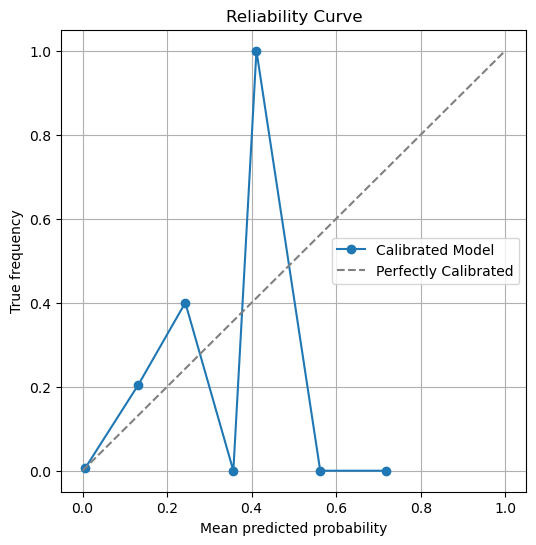

In [132]:

# Compute reliability curve
prob_true, prob_pred = calibration_curve(y_cal, y_cal_probs_4, n_bins=10, strategy='uniform')

# Plot reliability curve
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('True frequency')
plt.title('Reliability Curve')
plt.legend()
plt.grid()
plt.show()

In [133]:
# custom ECE calculation
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_edges[:-1]
    bin_uppers = bin_edges[1:]
    ece = 0.0
    for lower, upper in zip(bin_lowers, bin_uppers):
        mask = (y_prob > lower) & (y_prob <= upper)
        if np.any(mask):
            acc = np.mean(y_true[mask])
            conf = np.mean(y_prob[mask])
            ece += np.abs(acc - conf) * np.sum(mask) / len(y_true)
    return ece

ece_score = expected_calibration_error(y_cal, y_cal_probs_4)
print(f"Expected Calibration Error (ECE): {ece_score:.4f}")


Expected Calibration Error (ECE): 0.0003


In [134]:
# Calibrated probs for train and test
p_train = cal_model_4.predict_proba(X_train_proc)[:, 1]
p_test = cal_model_4.predict_proba(X_cal_proc)[:, 1]

# Compute average and threshold
avg_p_train = np.mean(p_train)
threshold_n = 5 * avg_p_train  # Or choose n=10, etc.

# Percentile-based threshold (e.g., top 0.1% of train scores)
threshold_pct = np.percentile(p_train, 99.9)

# Flag high-suspicion events in test set
rare_indices_n = np.where(p_test > threshold_n)[0]
rare_indices_pct = np.where(p_test > threshold_n)[0]

print(f"# Rare events based on our threshold: {len(rare_indices_n)}")
print(f"# events > 99.9 percentile: {len(rare_indices_pct)}")


# Rare events based on our threshold: 610
# events > 99.9 percentile: 610


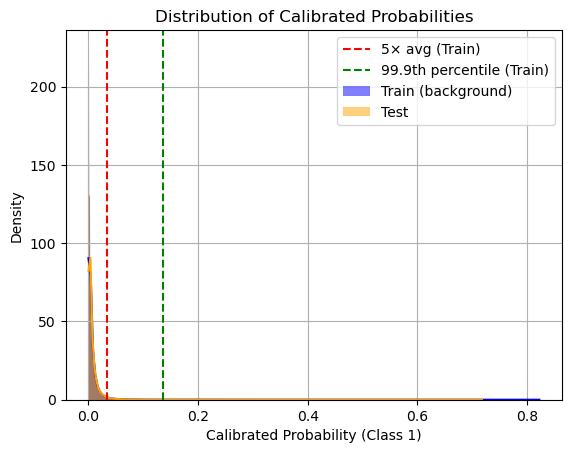

In [135]:
sns.histplot(p_train, label='Train (background)', kde=True, color='blue', stat='density')
sns.histplot(p_test, label='Test', kde=True, color='orange', stat='density')
plt.axvline(threshold_n, linestyle='--', color='red', label='5× avg (Train)')
plt.axvline(threshold_pct, linestyle='--', color='green', label='99.9th percentile (Train)')
plt.title("Distribution of Calibrated Probabilities")
plt.xlabel("Calibrated Probability (Class 1)")
plt.legend()
plt.grid()
plt.show()


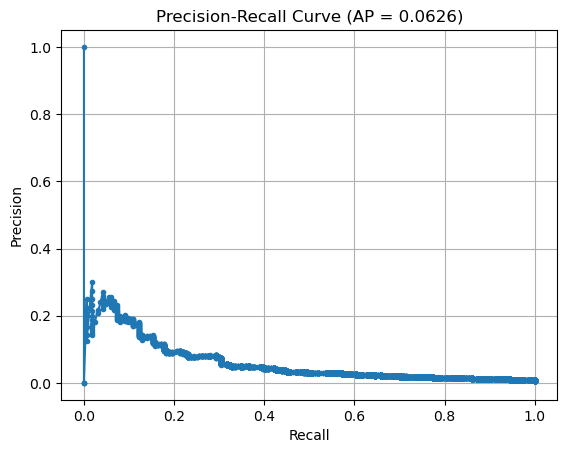

In [136]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_cal, p_test)
ap = average_precision_score(y_cal, p_test)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {ap:.4f})')
plt.grid()
plt.show()


## Model 5

In [137]:
threshold = 0.02  # or use your 5× avg line
y_proba = cal_model_5.predict_proba(X_cal_proc)[:, 1]
y_pred = (y_proba >= threshold).astype(int)

In [138]:
from sklearn.metrics import classification_report
print(classification_report(y_cal, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     24000
           1       0.04      0.41      0.08       164

    accuracy                           0.93     24164
   macro avg       0.52      0.67      0.52     24164
weighted avg       0.99      0.93      0.96     24164



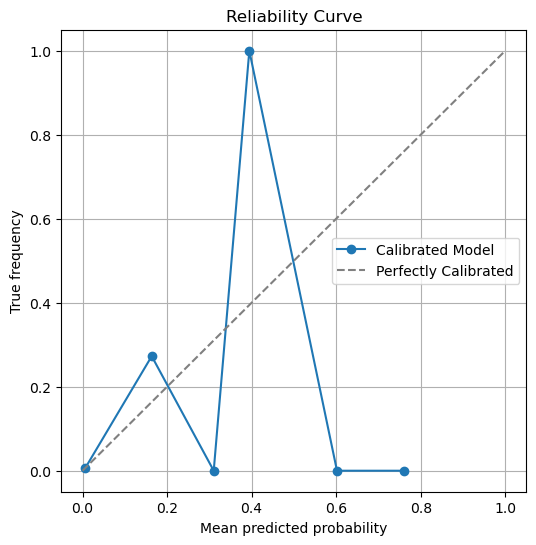

In [139]:

# Compute reliability curve
prob_true, prob_pred = calibration_curve(y_cal, y_cal_probs_5, n_bins=8, strategy='uniform')

# Plot reliability curve
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('True frequency')
plt.title('Reliability Curve')
plt.legend()
plt.grid()
plt.show()

In [140]:
# custom ECE calculation
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_edges[:-1]
    bin_uppers = bin_edges[1:]
    ece = 0.0
    for lower, upper in zip(bin_lowers, bin_uppers):
        mask = (y_prob > lower) & (y_prob <= upper)
        if np.any(mask):
            acc = np.mean(y_true[mask])
            conf = np.mean(y_prob[mask])
            ece += np.abs(acc - conf) * np.sum(mask) / len(y_true)
    return ece

ece_score = expected_calibration_error(y_cal, y_cal_probs_5)
print(f"Expected Calibration Error (ECE): {ece_score:.4f}")


Expected Calibration Error (ECE): 0.0003


In [141]:
# Calibrated probs for train and test
p_train = cal_model_5.predict_proba(X_train_proc)[:, 1]
p_test = cal_model_5.predict_proba(X_cal_proc)[:, 1]

# Compute average and threshold
avg_p_train = np.mean(p_train)
threshold_n = 5 * avg_p_train  # Or choose n=10, etc.

# Percentile-based threshold (e.g., top 0.1% of train scores)
threshold_pct = np.percentile(p_train, 99.9)

# Flag high-suspicion events in test set
rare_indices_n = np.where(p_test > threshold_n)[0]
rare_indices_pct = np.where(p_test > threshold_pct)[0]

print(f"# events > 5× avg: {len(rare_indices_n)}")
print(f"# events > 99.9 percentile: {len(rare_indices_pct)}")


# events > 5× avg: 600
# events > 99.9 percentile: 27


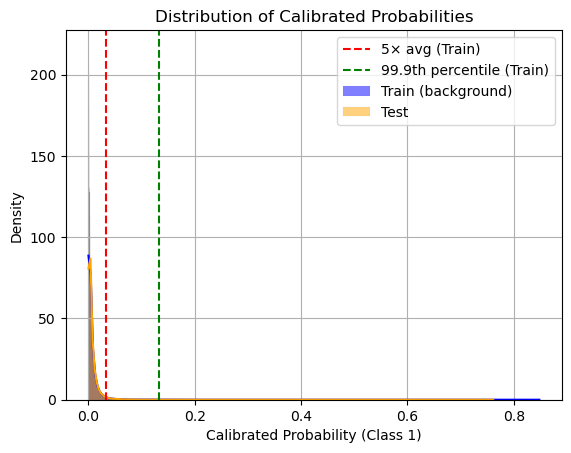

In [142]:
sns.histplot(p_train, label='Train (background)', kde=True, color='blue', stat='density')
sns.histplot(p_test, label='Test', kde=True, color='orange', stat='density')
plt.axvline(threshold_n, linestyle='--', color='red', label='5× avg (Train)')
plt.axvline(threshold_pct, linestyle='--', color='green', label='99.9th percentile (Train)')
plt.title("Distribution of Calibrated Probabilities")
plt.xlabel("Calibrated Probability (Class 1)")
plt.legend()
plt.grid()
plt.show()


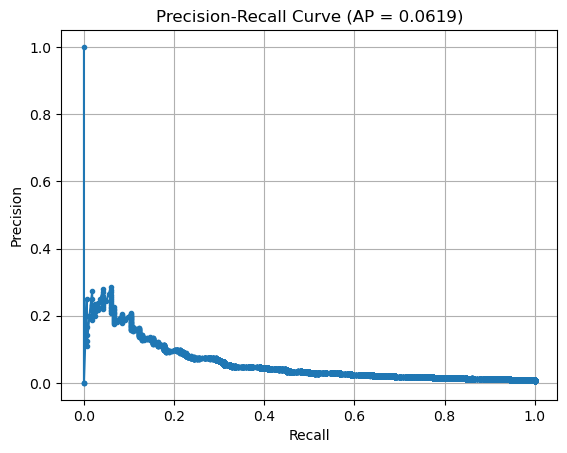

In [143]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_cal, p_test)
ap = average_precision_score(y_cal, p_test)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {ap:.4f})')
plt.grid()
plt.show()


## Model 6

In [144]:
threshold = 0.02
y_proba = cal_model_6.predict_proba(X_cal_proc)[:, 1]
y_pred = (y_proba >= threshold).astype(int)

In [145]:
from sklearn.metrics import classification_report
print(classification_report(y_cal, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     24000
           1       0.04      0.41      0.08       164

    accuracy                           0.93     24164
   macro avg       0.52      0.68      0.52     24164
weighted avg       0.99      0.93      0.96     24164



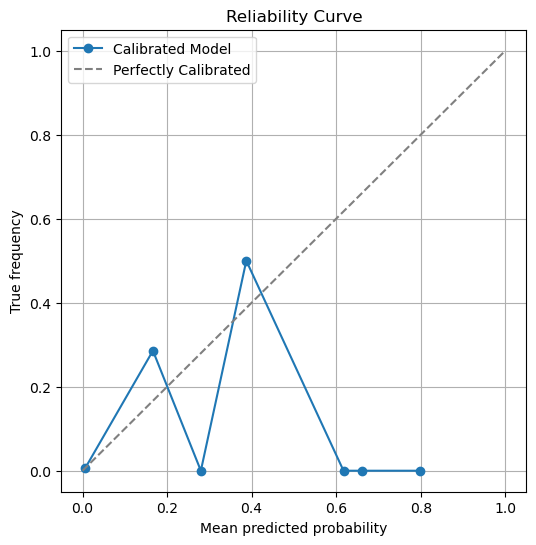

In [146]:

# Compute reliability curve
prob_true, prob_pred = calibration_curve(y_cal, y_cal_probs_6, n_bins=8, strategy='uniform')

# Plot reliability curve
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('True frequency')
plt.title('Reliability Curve')
plt.legend()
plt.grid()
plt.show()

In [147]:
# custom ECE calculation
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_edges[:-1]
    bin_uppers = bin_edges[1:]
    ece = 0.0
    for lower, upper in zip(bin_lowers, bin_uppers):
        mask = (y_prob > lower) & (y_prob <= upper)
        if np.any(mask):
            acc = np.mean(y_true[mask])
            conf = np.mean(y_prob[mask])
            ece += np.abs(acc - conf) * np.sum(mask) / len(y_true)
    return ece

ece_score = expected_calibration_error(y_cal, y_cal_probs_6)
print(f"Expected Calibration Error (ECE): {ece_score:.4f}")


Expected Calibration Error (ECE): 0.0004


In [148]:
# Calibrated probs for train and test
p_train = cal_model_6.predict_proba(X_train_proc)[:, 1]
p_test = cal_model_6.predict_proba(X_cal_proc)[:, 1]

# Compute average and threshold
avg_p_train = np.mean(p_train)
threshold_n = 5 * avg_p_train  # Or choose n=10, etc.

# Percentile-based threshold (e.g., top 0.1% of train scores)
threshold_pct = np.percentile(p_train, 99.9)

# Flag high-suspicion events in test set
rare_indices_n = np.where(p_test > threshold_n)[0]
#rare_indices_pct = np.where(p_test > threshold_pct)[0]

print(f"# events > 5× avg: {len(rare_indices_n)}")
print(f"# events > 99.9 percentile: {len(rare_indices_pct)}")


# events > 5× avg: 571
# events > 99.9 percentile: 27


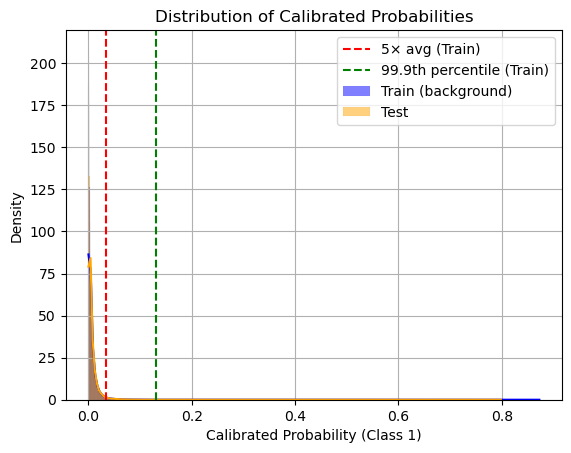

In [149]:
sns.histplot(p_train, label='Train (background)', kde=True, color='blue', stat='density')
sns.histplot(p_test, label='Test', kde=True, color='orange', stat='density')
plt.axvline(threshold_n, linestyle='--', color='red', label='5× avg (Train)')
plt.axvline(threshold_pct, linestyle='--', color='green', label='99.9th percentile (Train)')
plt.title("Distribution of Calibrated Probabilities")
plt.xlabel("Calibrated Probability (Class 1)")
plt.legend()
plt.grid()
plt.show()


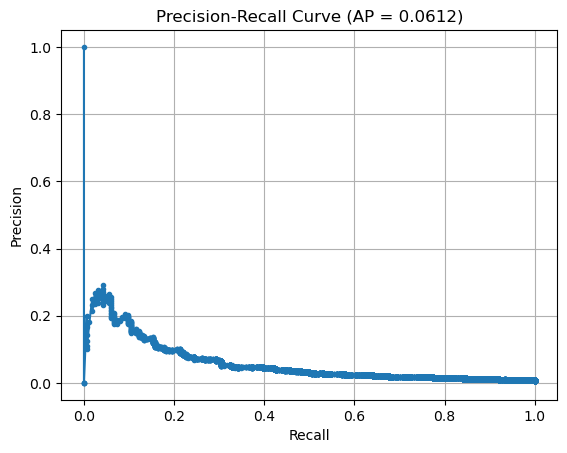

In [150]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_cal, p_test)
ap = average_precision_score(y_cal, p_test)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {ap:.4f})')
plt.grid()
plt.show()


Brier Score: 0.006611490630533237


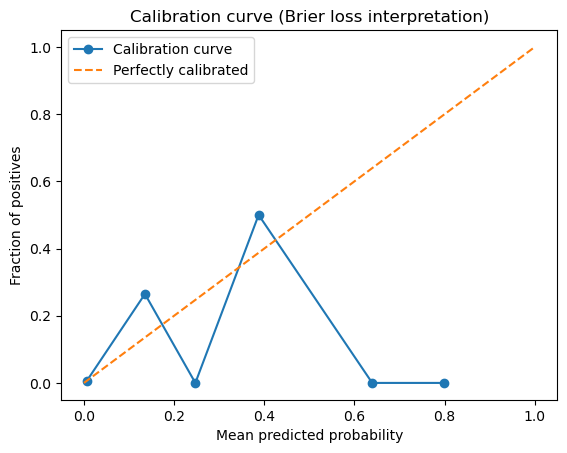

In [151]:
# predicted probabilities and true labels
probs = cal_model_6.predict_proba(X_cal_proc)[:, 1]
y_true = y_cal

# Brier score
print("Brier Score:", brier_score_loss(y_true, probs))

# Calibration curve (can help plot Brier loss behavior)
prob_true, prob_pred = calibration_curve(y_true, probs, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve (Brier loss interpretation)')
plt.legend()
plt.show()


Full Model Analysis

IndexError: list index out of range

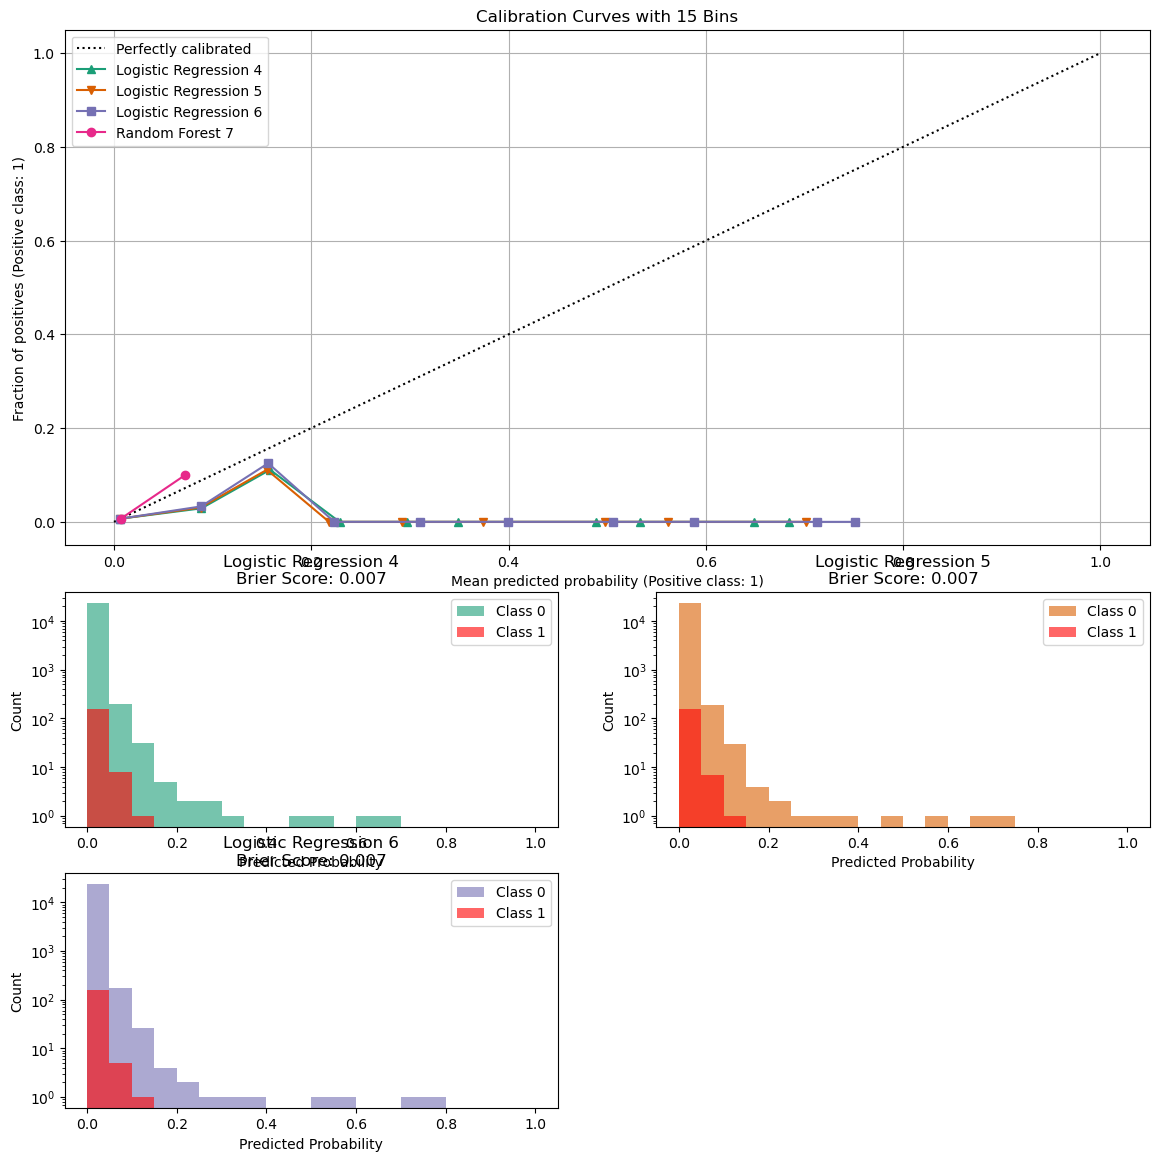

In [193]:
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss

fig = plt.figure(figsize=(14, 14))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

clf_list = [
    (cal_model_4, "Logistic Regression 4"),
    (cal_model_5, "Logistic Regression 5"),
    (cal_model_6, "Logistic Regression 6"),
    (cal_model_7, "Random Forest 7")
]

# 1. Calibration curve
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
ax_calibration_curve.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
markers = ["^", "v", "s", "o"]
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]


for i, (clf, name) in enumerate(clf_list):
    CalibrationDisplay.from_estimator(
        clf,
        X_val_proc,
        y_val,
        n_bins=15,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i]
    )

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Curves with 15 Bins")
ax_calibration_curve.legend(loc="upper left")

# 2. Histograms
grid_positions = [(2, 0), (2, 1), (3, 0)]
for i, (clf, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    y_prob = clf.predict_proba(X_val_proc)[:, 1]
    brier = brier_score_loss(y_val, y_prob)

    ax.hist(y_prob[y_val == 0], bins=20, range=(0, 1), alpha=0.6, label="Class 0", color=colors(i))
    ax.hist(y_prob[y_val == 1], bins=20, range=(0, 1), alpha=0.6, label="Class 1", color="red")
    ax.set_title(f"{name}\nBrier Score: {brier:.3f}")
    ax.set_xlabel("Predicted Probability")
    ax.set_ylabel("Count")
    ax.set_yscale("log")
    ax.legend()

plt.tight_layout()
plt.show()

# 3. Threshold tuning – separate figure per model
for i, (clf, name) in enumerate(clf_list):
    y_prob = clf.predict_proba(X_val_proc)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, y_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

    best_f1_idx = np.argmax(f1_scores)
    best_thresh_f1 = thresholds[best_f1_idx]

    best_recall_thresh = thresholds[np.argmax(recall)]

    print(f"\n{name}")
    print("Any NaNs in y_prob:", np.isnan(y_prob).any())
    print("Count of NaNs:", np.isnan(y_prob).sum())
    print("Min:", y_prob.min())
    print("Max:", y_prob.max())
    print("Mean:", y_prob.mean())
    print("Quantiles:", np.quantile(y_prob, [0, 0.25, 0.5, 0.75, 1.0]))
    print(f"Best F1 threshold: {best_thresh_f1:.2f}, F1: {f1_scores[best_f1_idx]:.3f}")
    print(f"Best Recall threshold: {best_recall_thresh:.2f}, Recall: {recall[np.argmax(recall)]:.3f}")

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precision[:-1], label="Precision")
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
    plt.axvline(best_thresh_f1, color="black", linestyle="--", label="Best F1")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Threshold Tuning: {name}")
    plt.legend()
    plt.grid(True)
    plt.show()


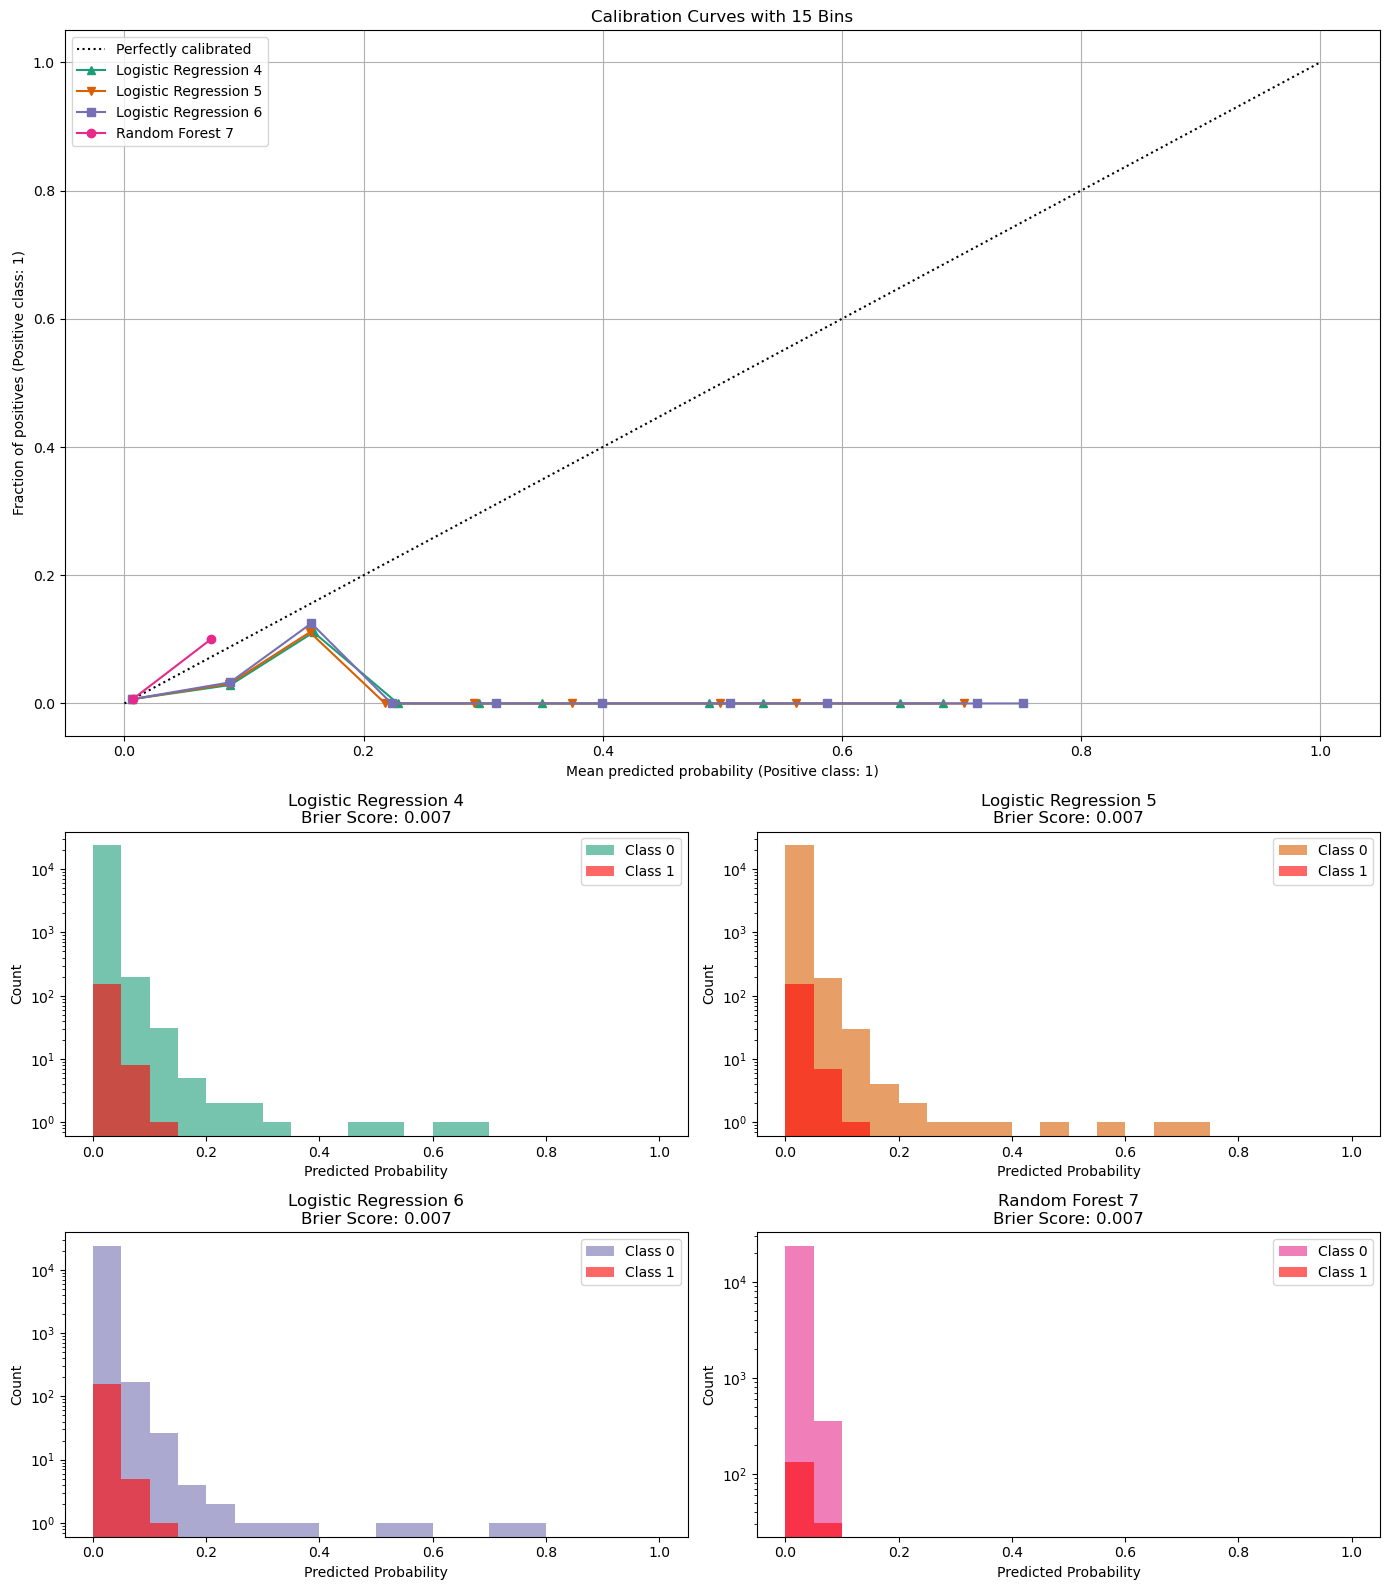


Logistic Regression 4
Any NaNs in y_prob: False
Count of NaNs: 0
Min: 1.0633206562913147e-10
Max: 0.6847422112095402
Mean: 0.006778327873472095
Quantiles: [1.06332066e-10 1.27761405e-03 3.33257049e-03 7.71996566e-03
 6.84742211e-01]
Best F1 threshold: 0.02, F1: 0.066
Best Recall threshold: 0.00, Recall: 1.000


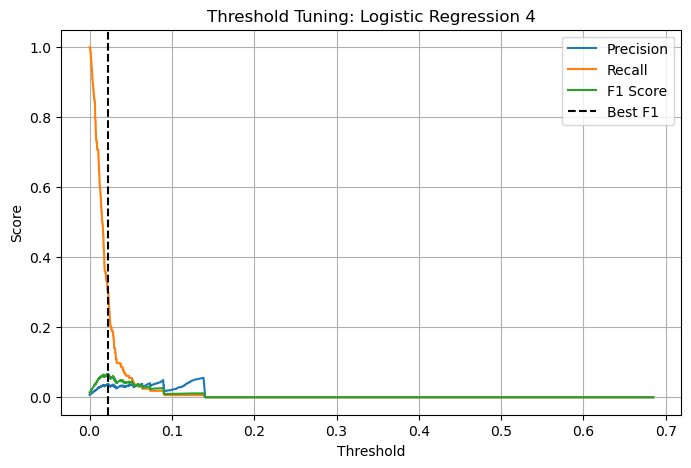


Logistic Regression 5
Any NaNs in y_prob: False
Count of NaNs: 0
Min: 1.605957956111294e-10
Max: 0.7209371554446335
Mean: 0.006767195143214537
Quantiles: [1.60595796e-10 1.31631086e-03 3.39702773e-03 7.80310514e-03
 7.20937155e-01]
Best F1 threshold: 0.02, F1: 0.065
Best Recall threshold: 0.00, Recall: 1.000


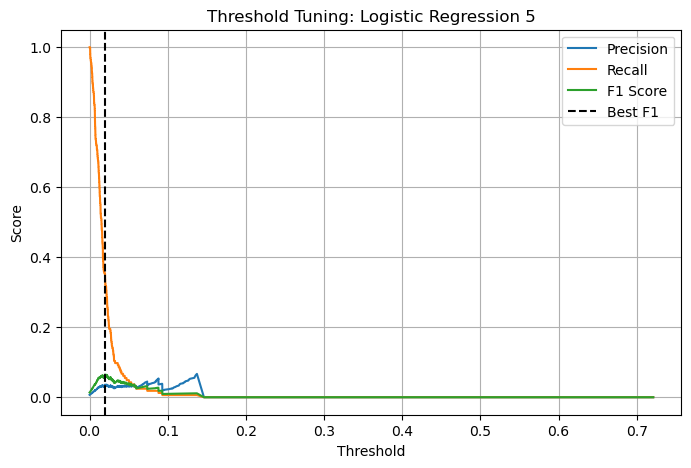


Logistic Regression 6
Any NaNs in y_prob: False
Count of NaNs: 0
Min: 2.44591803428633e-10
Max: 0.7515982277145714
Mean: 0.0067690451817460215
Quantiles: [2.44591803e-10 1.36543976e-03 3.47398723e-03 7.86275010e-03
 7.51598228e-01]
Best F1 threshold: 0.02, F1: 0.063
Best Recall threshold: 0.00, Recall: 1.000


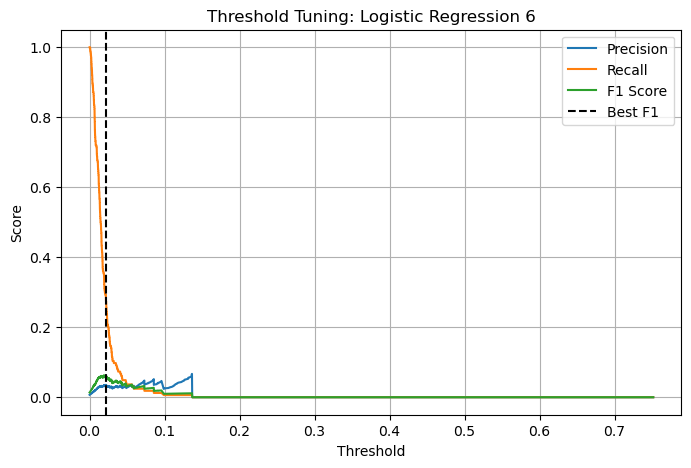


Random Forest 7
Any NaNs in y_prob: False
Count of NaNs: 0
Min: 0.00028147341591871583
Max: 0.08258053795036915
Mean: 0.006957654410793322
Quantiles: [0.00028147 0.00139369 0.00274518 0.00685213 0.08258054]
Best F1 threshold: 0.05, F1: 0.126
Best Recall threshold: 0.00, Recall: 1.000


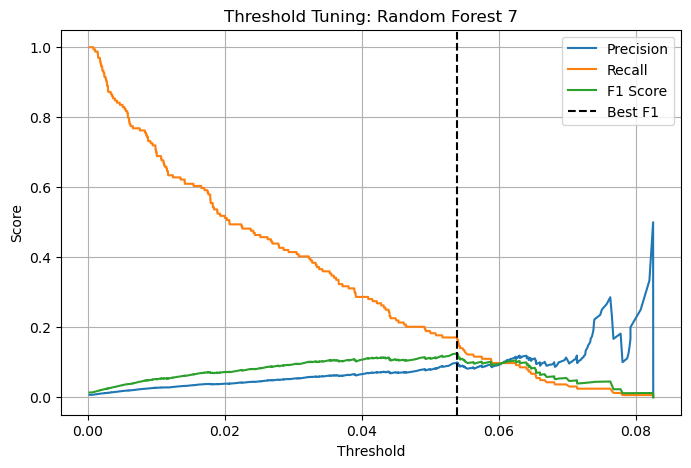

In [194]:
import math
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss, precision_recall_curve
import numpy as np

# Your model list
clf_list = [
    (cal_model_4, "Logistic Regression 4"),
    (cal_model_5, "Logistic Regression 5"),
    (cal_model_6, "Logistic Regression 6"),
    (cal_model_7, "Random Forest 7"),
    # Add more if needed
]

n_models = len(clf_list)
n_cols = 2  # Number of histogram columns
n_hist_rows = math.ceil(n_models / n_cols)
total_rows = 2 + n_hist_rows  # 2 rows for calibration curve

# Setup figure and GridSpec
fig = plt.figure(figsize=(14, 4 * total_rows))
gs = GridSpec(total_rows, n_cols)
colors = plt.get_cmap("Dark2")
markers = ["^", "v", "s", "o", "X", "P", "D", "*", "+"]  # extend if needed

# 1. Calibration curve on top
ax_calibration_curve = fig.add_subplot(gs[:2, :])
ax_calibration_curve.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for i, (clf, name) in enumerate(clf_list):
    CalibrationDisplay.from_estimator(
        clf,
        X_val_proc,
        y_val,
        n_bins=15,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i % 8),
        marker=markers[i % len(markers)]
    )

ax_calibration_curve.set_title("Calibration Curves with 15 Bins")
ax_calibration_curve.grid()
ax_calibration_curve.legend(loc="upper left")

# 2. Histogram subplots
for i, (clf, name) in enumerate(clf_list):
    row = 2 + (i // n_cols)
    col = i % n_cols
    ax = fig.add_subplot(gs[row, col])

    y_prob = clf.predict_proba(X_val_proc)[:, 1]
    brier = brier_score_loss(y_val, y_prob)

    ax.hist(y_prob[y_val == 0], bins=20, range=(0, 1), alpha=0.6, label="Class 0", color=colors(i % 8))
    ax.hist(y_prob[y_val == 1], bins=20, range=(0, 1), alpha=0.6, label="Class 1", color="red")
    ax.set_title(f"{name}\nBrier Score: {brier:.3f}")
    ax.set_xlabel("Predicted Probability")
    ax.set_ylabel("Count")
    ax.set_yscale("log")
    ax.legend()

plt.tight_layout()
plt.show()

# 3. Threshold tuning – one figure per model
for i, (clf, name) in enumerate(clf_list):
    y_prob = clf.predict_proba(X_val_proc)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, y_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_f1_idx = np.argmax(f1_scores)
    best_thresh_f1 = thresholds[best_f1_idx]
    best_recall_thresh = thresholds[np.argmax(recall)]

    print(f"\n{name}")
    print("Any NaNs in y_prob:", np.isnan(y_prob).any())
    print("Count of NaNs:", np.isnan(y_prob).sum())
    print("Min:", y_prob.min())
    print("Max:", y_prob.max())
    print("Mean:", y_prob.mean())
    print("Quantiles:", np.quantile(y_prob, [0, 0.25, 0.5, 0.75, 1.0]))
    print(f"Best F1 threshold: {best_thresh_f1:.2f}, F1: {f1_scores[best_f1_idx]:.3f}")
    print(f"Best Recall threshold: {best_recall_thresh:.2f}, Recall: {recall[np.argmax(recall)]:.3f}")

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precision[:-1], label="Precision")
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
    plt.axvline(best_thresh_f1, color="black", linestyle="--", label="Best F1")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Threshold Tuning: {name}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [196]:
import pandas as pd
import numpy as np

anomaly_results = []

for clf, name in clf_list:
    print(f"Model: {name}")
    
    # 1. Get predicted probabilities
    y_prob = clf.predict_proba(X_val_proc)[:, 1]
    
    # 2. Calculate mean and quantiles of prob for true class 1
    mean_prob_class1 = y_prob[y_val == 1].mean()
    q75_prob_class1 = np.quantile(y_prob[y_val == 1], 0.75)
    
    # 3. Identify samples where:
    #   - true label is 0
    #   - predicted probability is greater than class 1 average
    mask_high_risk = (y_val == 0) & (y_prob > mean_prob_class1)
    
    # Optional: stricter mask using 75th percentile
    # mask_high_risk = (y_val == 0) & (y_prob > q75_prob_class1)
    
    # 4. Create DataFrame of results
    df_result = pd.DataFrame({
        "model": name,
        "y_val": y_val,
        "y_prob": y_prob,
        "pred_class": clf.predict(X_val_proc),
        "high_risk_anomaly": mask_high_risk
    })

    n_total = df_result.shape[0]
    n_high_risk = mask_high_risk.sum()
    avg_prob_class0 = y_prob[y_val == 0].mean()
    
    print(f"Mean probability for class 1: {mean_prob_class1:.3f}")
    print(f"Mean probability for class 0: {avg_prob_class0:.3f}")
    print(f"High-risk class 0 points detected: {n_high_risk} / {n_total} ({n_high_risk/n_total:.2%})")

    anomaly_results.append(df_result[mask_high_risk])

# Concatenate all high-risk examples across models
all_anomalies_df = pd.concat(anomaly_results, ignore_index=True)

# Sort by highest probability first
all_anomalies_df = all_anomalies_df.sort_values(by="y_prob", ascending=False)

# Show top anomalies
all_anomalies_df


Model: Logistic Regression 4
Mean probability for class 1: 0.019
Mean probability for class 0: 0.007
High-risk class 0 points detected: 1701 / 24164 (7.04%)
Model: Logistic Regression 5
Mean probability for class 1: 0.019
Mean probability for class 0: 0.007
High-risk class 0 points detected: 1749 / 24164 (7.24%)
Model: Logistic Regression 6
Mean probability for class 1: 0.018
Mean probability for class 0: 0.007
High-risk class 0 points detected: 1791 / 24164 (7.41%)
Model: Random Forest 7
Mean probability for class 1: 0.027
Mean probability for class 0: 0.007
High-risk class 0 points detected: 1395 / 24164 (5.77%)


,model,y_val,y_prob,pred_class,high_risk_anomaly
4733,Logistic Regression 6,0,0.751598,1,True
2949,Logistic Regression 5,0,0.720937,1,True
3689,Logistic Regression 6,0,0.713066,1,True
1198,Logistic Regression 4,0,0.684742,1,True
1932,Logistic Regression 5,0,0.682683,1,True
...,...,...,...,...,...
5094,Logistic Regression 6,0,0.018284,0,True
4586,Logistic Regression 6,0,0.018275,0,True
3591,Logistic Regression 6,0,0.018258,0,True
4496,Logistic Regression 6,0,0.018255,0,True


In [197]:
all_anomalies_df['model'].value_counts()

model
Logistic Regression 6    1791
Logistic Regression 5    1749
Logistic Regression 4    1701
Random Forest 7          1395
Name: count, dtype: int64